# Introdução

Este notebook é uma exploração e análise de dados do desafio [COVID-19 - Clinical Data to assess diagnosis](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) do Hospital Sírio-Libanês. Esse dataset foi publicado no contexto de predição da necessidade de internações baseados em dados clínicos para COVID-19.

Na análise a seguir, vamos explorar os dados e como estes se relacionam, verificar a qualidade dos dados e realizar a limpeza de dados desnecessários.

O Sírio-Libanês dividio os dados em:
- Informações demográficas
- Doenças pré-existentes
- Sinais vitais
- Resultados de exame de sangue.

# Setup

## Import and Constants

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys
sys.path.append("../scripts/")
from helper import *

In [2]:
GRAY4 = '#646369'
GRAY5 = '#76787B'
GENDER_0 = '#59AB61'
GENDER_1 = '#3791AB'
ABOVE65_0 = '#74F782'
ABOVE65_1 = '#5CD5F7'
ICU_0 = '#ADA476'
ICU_1 = '#FF4336'

ICU_0_LABEL = 'Não Admitido na UTI'
ICU_1_LABEL = 'Admitido na UTI'

## Load Data

In [3]:
path_dados = '../raw_data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(path_dados)
dados["PATIENT_VISIT_IDENTIFIER"] = dados["PATIENT_VISIT_IDENTIFIER"].astype("category")
dados["AGE_ABOVE65"] = dados["AGE_ABOVE65"].astype("category")
dados["AGE_PERCENTIL"] = dados["AGE_PERCENTIL"].astype("category")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


# Exploratory Data Analysis

Os dados são divididos em 4 grupos:
* Informação demográfica
    1. `AGE_ABOVE65`: Se o paciente tem 65 anos ou mais
    2. `AGE_PERCENTIL`: Qual a idade do paciente em janelas de 10 em 10 anos
    3. `GENDER`: Sexo biológico do paciente
* Doenças pré-existentes
    1. `DISEASE GROUPING`: Paciente tem uma condição não específicada que o Hospital Sírio-Libanês considerou relevante numerados de 1 a 6.
    2. `HTN`: Se o paciente tem ou não hipertensão
    3. `IMMUNOCOMPROMISED`: Os pacientes imunocomprometidos são aqueles cujos mecanismos normais de defesa contra infecção estão comprometidos.
    4. `OTHER`: Ou algum outro tipo de doença.
* Sinais vitais
    1. Os sinais vitais são `BLOODPRESSURE_DIASTOLIC`, `BLOODPRESSURE_SISTOLIC`, `HEART_RATE`, `OXYGEN_SATURATION`, `RESPIRATORY_RATE`, `TEMPERATURE`.
    2. Para cada sinal vital, foram calculados os valores `DIFF`, `DIFF_REL`, `MAX`, `MEAN`, `MEDIAN`, `MIN`.
* Resultados do exame de sangue
    1. São 36 resultaods medidos nos exames, estes resultados são mensurados em `DIFF`, `MAX`, `MEAN`, `MEDIAN`, `MIN`.

Cada linha dos dados representa um paciente, identificado por `PATIENT_VISIT_IDENTIFIER`, em uma janela de tempo (Coluna `WINDOW`) e como resultado, temos que o paciênte foi ou não transferido para UTI. (Coluna `ICU`).

A coluna `WINDOW` tem como valores:

| Window | Descrição |
|------|------|
| 0-2 | De 0 to 2 desde a admissão |
| 2-4 | De 2 à 4 desde a admissão |
| 4-6 | De 4 to 6 desde a admissão |
| 6-12 | De 6 to 12 desde a admissão |
| Above-12 | Acima de 12 desde a admissão |

A coluna `ICU` identifica em qual janela de tempo o paciente foi transferido a UTI:

| ICU | Descrição |
|------|------|
| 0 | Não adimitido na UTI |
| 1 | Adimitido na UTI |

## Informações demográficas

Pegando apenas a primeira linha por paciente, dado que esses dados são invariáveis a cada hora

Cada paciente pode ter uma ou mais entradas no dataset e estes são identificadas `PATIENT_VISIT_IDENTIFIER`. Como a cada janela de tempo, os sinais vitais e resuldados de sangue variam, mas os dados demográficos não, vamos analisar apenas uma linha para cada paciente.

In [4]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW']=='0-2']

demographic_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'ICU']
demographic_data = dados.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window).reset_index(drop=True)[demographic_columns]
demographic_data#.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,ICU
0,1,60th,0,1
1,1,90th,1,1
2,0,10th,0,1
3,0,40th,1,0
4,0,10th,0,0
...,...,...,...,...
380,0,40th,1,1
381,1,Above 90th,0,0
382,0,50th,0,1
383,0,40th,1,0


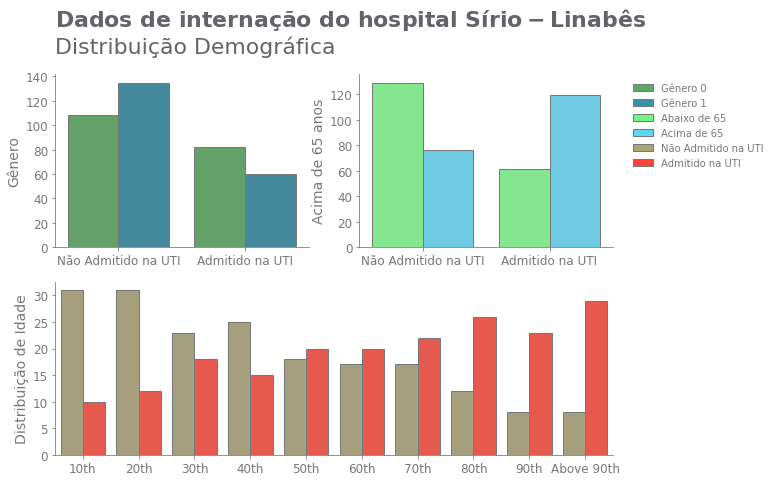

In [5]:
demographic_distribution_plot(demographic_data)

Ao observar o gráfico de gênero, onde 0 é o gênero masculino e 1 o feminino como explicitado pelo autor no forum do [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19/discussion/164019), é possível ver que apenas do genêro feminino ser mais representativo nas amostras, o sexo masculino é o mais adimitido na UTI. De acordo com o artigo de [1].
> Generally, females are more resistant to infections than men, and this is possibly mediated by several factors including sex hormones and high expression of coronavirus receptors (ACE 2) in men but also life style, such as higher levels of smoking and drinking among men as compared to women. Additionally, women have more responsible attitude toward the Covid-19 pandemic than men. [1] 

O gráfico de Acima de 65 anos mostra uma forte relação na susceptibilidade de internação dada a idade, que reforçado no gráfico de distribuição de idade, onde vemos uma relação direta entre o avançar da idade e as internações na UTI.

[1] Bwire GM. Coronavirus: Why Men are More Vulnerable to Covid-19 Than Women? [published online ahead of print, 2020 Jun 4]. SN Compr Clin Med. 2020;1-3. doi:10.1007/s42399-020-00341-w

## Doenças Pré-Existentes

Assim como os dados demográficos, as doenças pré-existentes dos pacientes não variam com o tempo, portanto vamos selecionar apenas uma linha por paciente.

In [6]:
preexisting_disease_columns = ['PATIENT_VISIT_IDENTIFIER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'ICU']
preexisting_disease_data = dados.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window).reset_index(drop=True)[preexisting_disease_columns]#.reset_index()
preexisting_disease_data
# preexisting_disease_data_melt = preexisting_disease_data.melt(id_vars=['PATIENT_VISIT_IDENTIFIER', 'ICU'], value_vars=preexisting_disease_columns[:-1],
#         var_name='Doenças Pré-Existentes', value_name='value')
# preexisting_disease_data_melt

,PATIENT_VISIT_IDENTIFIER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ICU
0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
380,380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
381,381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
382,382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
383,383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


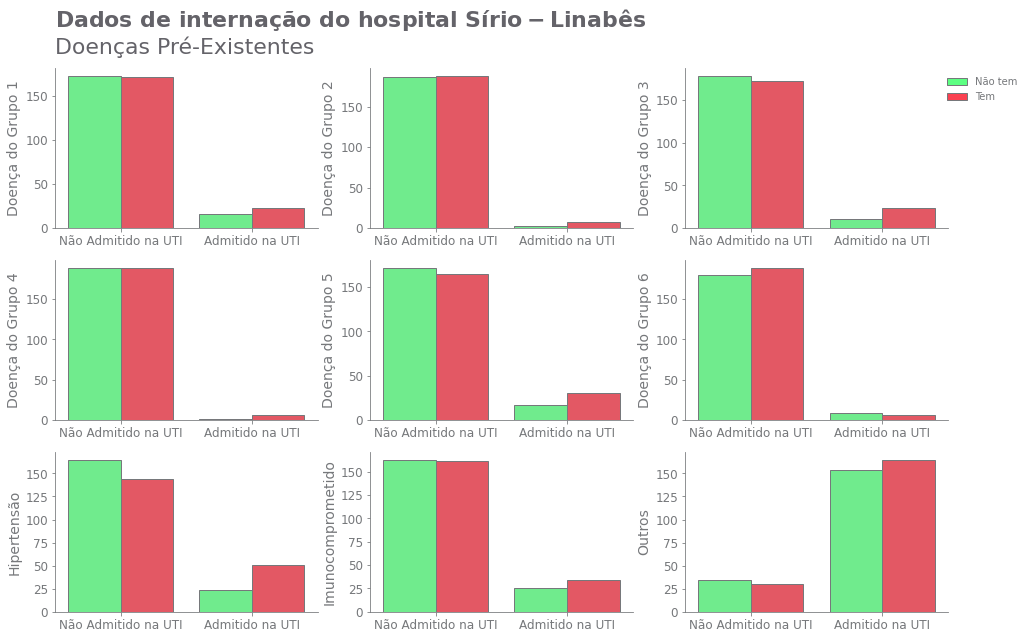

In [7]:
prexisting_disease_plot(preexisting_disease_data)

Os dados de doenças pré-existentes contam a história do paciente anterior a internação e podem ser fatores a aumentar a sua possibilidade de evolução para um caso mais grave. Algumas doenças como o grupo 2, 4 e 6 tem pouca representatividade nos pacientes que foram à UTI, enquanto que hipertensão é bem representativo.

O fator de risco causade pela hipertenção é tão notório, que a World Health Organization (Organização Mundial da Saúde) publicou uma nota sobre a relação da hipertensão com o risco de evolução de casos mais graves de COVID-19.
> Almost all available evidence suggests that hypertension increases the risk of severe COVID-19, defined as, admission to intensive care, clinically-defined severity or a combination of these; or mortality. It was sometimes unclear, however, whether this prognostic profile was independent of other risk factors [...][2]

[2] WHO. Hypertension and COVID-19. 2021. WHO/2019-nCoV/Sci_Brief/Hypertension/2021.1

## Sinais Vitais

Os sinais vitais aferidos são:
* `BLOODPRESSURE_DIASTOLIC` ou Pressão Arterial Diastólica (PAD)
* `BLOODPRESSURE_SISTOLIC` ou Pressão Arterial Sistólica (PAS)
* `HEART_RATE` ou Frequência Cardiaca
* `OXYGEN_SATURATION` ou Saturação do Oxigênio
* `RESPIRATORY_RATE` ou Frequência Respiratória
* `TEMPERATURE` ou Temperatura

Onde o resultados destas medições foram préviamente calculadas são:
* `MIN` Minimo
* `MAX` Máximo
* `MEAN` Média
* `MEDIAN` Mediana
* `DIFF` Diferença
    * É a diferença entre os valores máximo e mínimo (`max - min`)
* `DIFF_REL` Diferença Relativa
    * É o quociente entre diferença e mediana (`diff / median`)
   
Estas medidas são sufixos aos sinais vitais, portanto, temos 36 colunas de dados de sinais vitais.

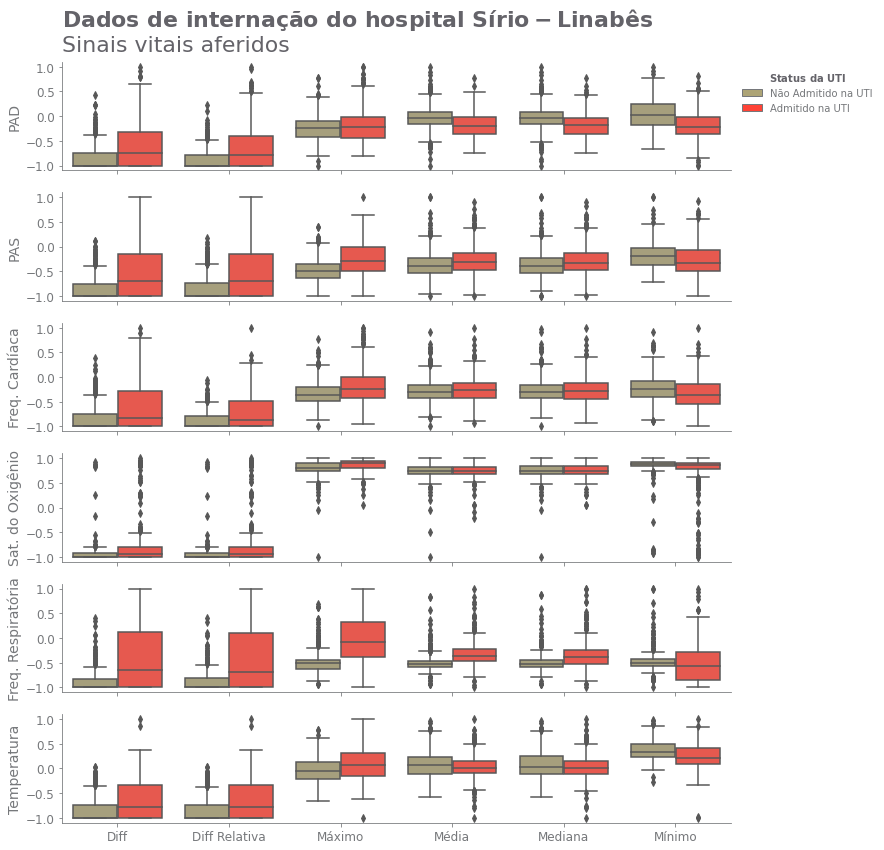

In [8]:
suptitle = 'Dados de internação do hospital Sírio-Linabês'
subtitle = 'Sinais vitais aferidos'
vital_signs_plot(dados, suptitle, subtitle)

É possível notar forte relações nos sinais vitais entre os pacientes que foram enviados a UTI ou não, como no caso da frequência respitatória.
Porém, a descrição do problema comunica que é necessário realizar a preedição da necessidade de UTI o mais rápido possível. Vamos olhar apenas a janela de tempo entre 0-2 horas.

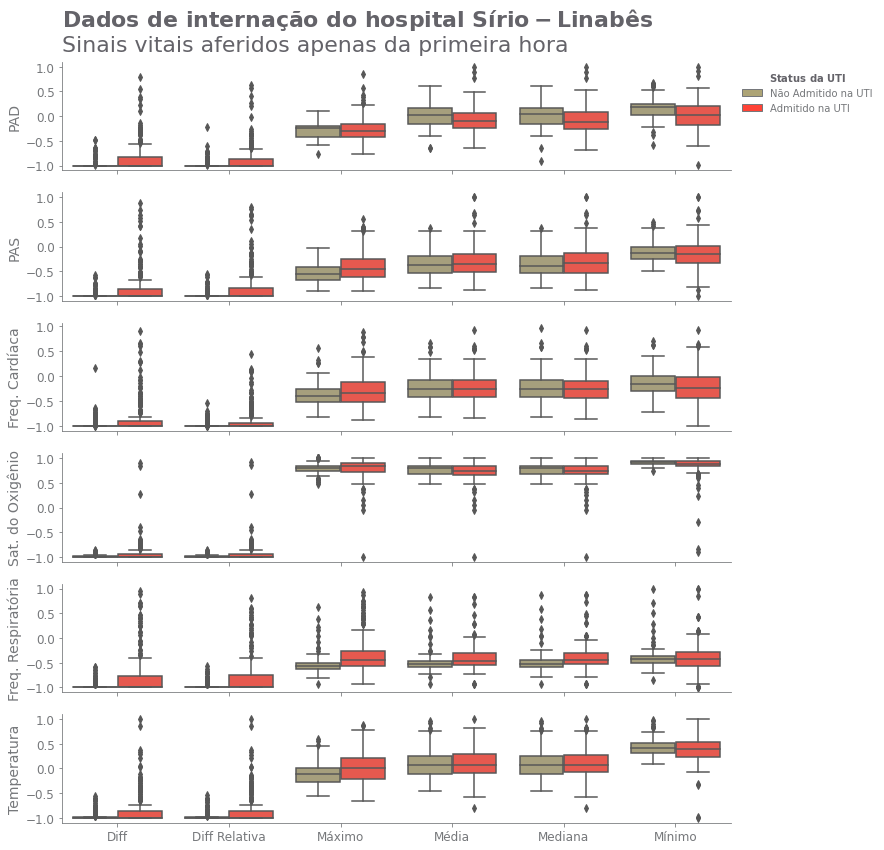

In [9]:
attributes_suffix = ['DIFF', 'DIFF_REL', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
vital_signs = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE']
vital_signs_columns = [f'{vs}_{attr}'for vs in vital_signs for attr in attributes_suffix]
dados_first_hour = dados.copy()
dados_first_hour[vital_signs_columns] = dados.groupby(['PATIENT_VISIT_IDENTIFIER', 'ICU'], as_index=False)[vital_signs_columns].fillna(method='bfill').fillna(method='ffill')
dados_first_hour = dados_first_hour.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window).reset_index(drop=True)

suptitle = 'Dados de internação do hospital Sírio-Linabês'
subtitle = 'Sinais vitais aferidos apenas da primeira hora'
vital_signs_plot(dados_first_hour, suptitle, subtitle)

Quando observávamos a evolução completa do paciente, tinhamos dados claros sobre a internação. Ao oberservar apenas a primeira janela de tempo, os dados ficam mais dificies de distinguir.

## Resultados do exame de sangue

Temos 36 dados extraídos do exame de sangue, estes resultados são medidos em mínimo, máximo, média, mediana e diferença. Com isso, temos 180 colunas de dados. Vamos usar o `describe` para analise a distribuição desses valores.

In [10]:
attributes_suffix = ['DIFF', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
blood_results = ['ALBUMIN', 'BE_ARTERIAL', 'BE_VENOUS', 'BIC_ARTERIAL', 'BIC_VENOUS', 'BILLIRUBIN', 'BLAST', 'CALCIUM', 'CREATININ', 'FFA', 'GGT', 'GLUCOSE', 'HEMATOCRITE', 'HEMOGLOBIN', 'INR', 'LACTATE', 'LEUKOCYTES', 'LINFOCITOS', 'NEUTROPHILES', 'P02_ARTERIAL', 'P02_VENOUS', 'PC02_ARTERIAL', 'PC02_VENOUS', 'PCR', 'PH_ARTERIAL', 'PH_VENOUS', 'PLATELETS', 'POTASSIUM', 'SAT02_ARTERIAL', 'SAT02_VENOUS', 'SODIUM', 'TGO', 'TGP', 'TTPA', 'UREA', 'DIMER']
blood_results_columns = [f'{blood}_{attr}' for blood in blood_results for attr in attributes_suffix]

blood_results_data = dados[blood_results_columns].copy()
# blood_results_data = blood_results_data.replace(-1, np.nan)
# blood_results_data = blood_results_data.replace(1, np.nan)
blood_results_data.describe()


,ALBUMIN_DIFF,ALBUMIN_MAX,ALBUMIN_MEAN,ALBUMIN_MEDIAN,ALBUMIN_MIN,BE_ARTERIAL_DIFF,BE_ARTERIAL_MAX,BE_ARTERIAL_MEAN,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MIN,...,UREA_DIFF,UREA_MAX,UREA_MEAN,UREA_MEDIAN,UREA_MIN,DIMER_DIFF,DIMER_MAX,DIMER_MEAN,DIMER_MEDIAN,DIMER_MIN
count,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,...,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000
mean,-1.0,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,...,-1.0,-0.830181,-0.830181,-0.830181,-0.830181,-1.0,-0.954177,-0.954177,-0.954177,-0.954177
std,0.0,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,...,0.0,0.150934,0.150934,0.150934,0.150934,0.0,0.123582,0.123582,0.123582,0.123582
min,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-0.898795,-0.898795,-0.898795,-0.898795,-1.0,-0.978877,-0.978877,-0.978877,-0.978877
50%,-1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-0.874699,-0.874699,-0.874699,-0.874699,-1.0,-0.978029,-0.978029,-0.978029,-0.978029
75%,-1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-0.812048,-0.812048,-0.812048,-0.812048,-1.0,-0.968315,-0.968315,-0.968315,-0.968315
max,-1.0,1.000000,1.000000,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000,1.000000,...,-1.0,1.000000,1.000000,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000,1.000000


Temos que todas as colunas de `DIFF`, aparentemente, não foram preenchidas ou tiveram algum problema de _feature engineering_. Outro ponto importante é, Entre os demais valores da mesma medição são iguais.

Vamos investigar primeiro as colunas de `DIFF`.

### Colunas `DIFF`

Vamos analisar os dados das colunas `DIFF`.

In [11]:
blood_results_diff_columns = [f'{blood}_DIFF' for blood in blood_results]

blood_results_diff_data = dados[blood_results_diff_columns].copy()
# blood_results_diff_data = blood_results_diff_data.replace(-1, 0)
print(f'Soma de todos os valores da coluna DIFF: {blood_results_diff_data.sum().sum()}')
print(f'{dados[blood_results_diff_columns].melt().value_counts()}')

Soma de todos os valores da coluna DIFF: -29556.0
variable             value
ALBUMIN_DIFF         -1.0     821
BE_ARTERIAL_DIFF     -1.0     821
P02_ARTERIAL_DIFF    -1.0     821
P02_VENOUS_DIFF      -1.0     821
PC02_ARTERIAL_DIFF   -1.0     821
PC02_VENOUS_DIFF     -1.0     821
PCR_DIFF             -1.0     821
PH_ARTERIAL_DIFF     -1.0     821
PH_VENOUS_DIFF       -1.0     821
PLATELETS_DIFF       -1.0     821
POTASSIUM_DIFF       -1.0     821
SAT02_ARTERIAL_DIFF  -1.0     821
SAT02_VENOUS_DIFF    -1.0     821
SODIUM_DIFF          -1.0     821
TGO_DIFF             -1.0     821
TGP_DIFF             -1.0     821
TTPA_DIFF            -1.0     821
NEUTROPHILES_DIFF    -1.0     821
LINFOCITOS_DIFF      -1.0     821
LEUKOCYTES_DIFF      -1.0     821
CREATININ_DIFF       -1.0     821
BE_VENOUS_DIFF       -1.0     821
BIC_ARTERIAL_DIFF    -1.0     821
BIC_VENOUS_DIFF      -1.0     821
BILLIRUBIN_DIFF      -1.0     821
BLAST_DIFF           -1.0     821
CALCIUM_DIFF         -1.0     821
DIMER

Os dados das colunas não estão vazios, porém, só apresetam o valor -1 preenchido. Portanto, esta coluna não tem valor na previsão de internação.

### Valores de MAX, MEAN, MEDIAN e MIN

Vamos observar se há distinção nos valores preenchidos comparando todos os resultados de sangue e seus sufixos.

In [12]:
attributes_suffix = ['MAX', 'MEAN', 'MEDIAN', 'MIN']

eq_columns = []
neq_columns = []

for blood in blood_results:#[:3]:
    br_columns = [f'{blood}_{attr}' for attr in attributes_suffix]
    if all([blood_results_data[br_columns[0]].equals(blood_results_data[col]) for col in br_columns[1:]]):
        eq_columns.append(blood)
    else:
        neq_columns.append(blood)
print(f'Colunuas com valores iguais entre os atributos: {eq_columns}')
print(f'Colunuas com valores iguais diferente os atributos: {neq_columns}')

Colunuas com valores iguais entre os atributos: ['ALBUMIN', 'BE_ARTERIAL', 'BE_VENOUS', 'BIC_ARTERIAL', 'BIC_VENOUS', 'BILLIRUBIN', 'BLAST', 'CALCIUM', 'CREATININ', 'FFA', 'GGT', 'GLUCOSE', 'HEMATOCRITE', 'HEMOGLOBIN', 'INR', 'LACTATE', 'LEUKOCYTES', 'LINFOCITOS', 'NEUTROPHILES', 'P02_ARTERIAL', 'P02_VENOUS', 'PC02_ARTERIAL', 'PC02_VENOUS', 'PCR', 'PH_ARTERIAL', 'PH_VENOUS', 'PLATELETS', 'POTASSIUM', 'SAT02_ARTERIAL', 'SAT02_VENOUS', 'SODIUM', 'TGO', 'TGP', 'TTPA', 'UREA', 'DIMER']
Colunuas com valores iguais diferente os atributos: []


Como todos esses valores são iguais, vamos selecionar apenas 1 deles.

## Comparação dos resultados de exame de sangue completos e apenas primeira janela

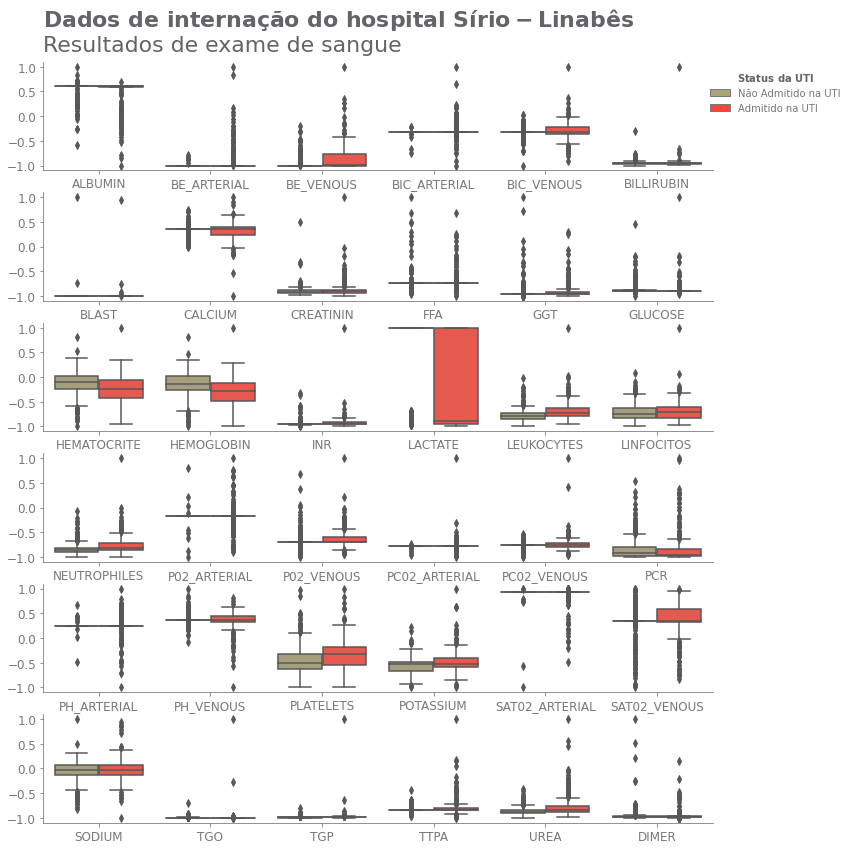

In [13]:
suptitle = 'Dados de internação do hospital Sírio-Linabês'
subtitle = 'Resultados de exame de sangue'
blood_results_plot(dados, suptitle, subtitle)

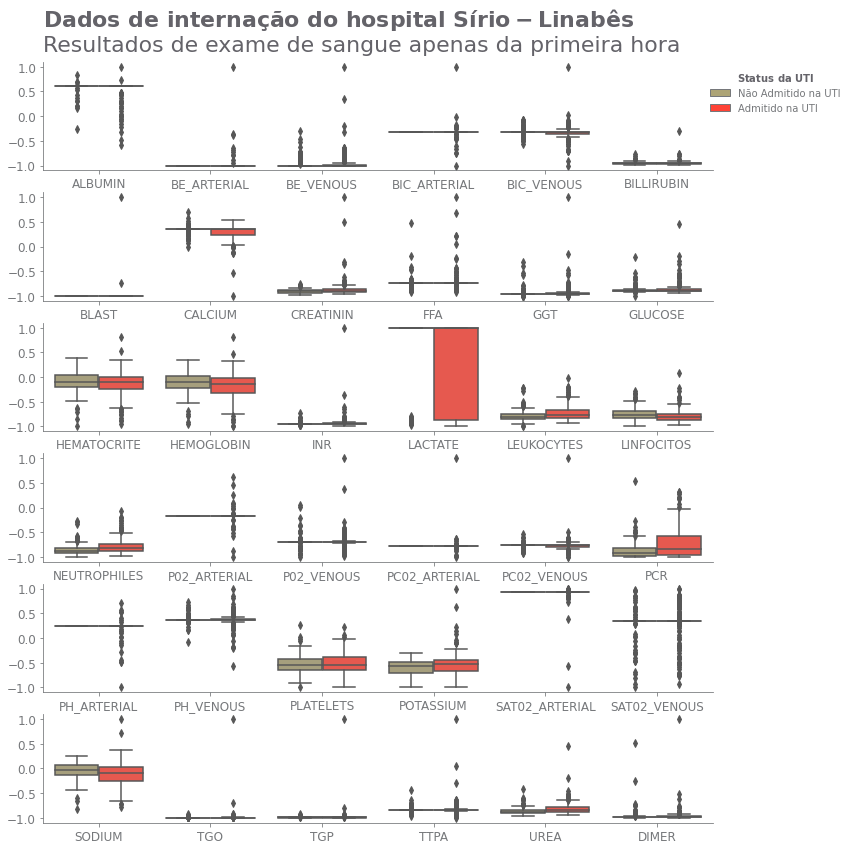

In [14]:
dados_first_hour = dados.copy()
dados_first_hour[blood_results_columns] = dados.groupby(['PATIENT_VISIT_IDENTIFIER', 'ICU'], as_index=False)[blood_results_columns].fillna(method='bfill').fillna(method='ffill')
dados_first_hour = dados_first_hour.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window).reset_index(drop=True)

suptitle = 'Dados de internação do hospital Sírio-Linabês'
subtitle = 'Resultados de exame de sangue apenas da primeira hora'
blood_results_plot(dados_first_hour, suptitle, subtitle)

Temos conclusões similares ao dos sinais vitais, quando olhamos todos os dados, é possível olhar com clareza quem irá a UTI. Porém, ao utilizar apenas a primeira hora, a previsão fica mais nublada.

# Conclusão

A EDA é de extra importancia para o entendimento dos dados e até redução de dimensionalidade. Não foi preciso utilizar técnicas matemáticas avançadas como a correlação para remover colunas que não são importantes para a solução do problema.

Agora, com os dados compreendidos e reduzidos em dimensionalidade, podemos avançar para a criação de um modelo de previsão se o paciente vai ou não precisar de UTI.

# Dataset final

Observamos colunas desnecessárias ao nosso dataset, então, podemos removelas e ter um conjunto de dados mais conciso.

Para as doenças pré-existentes, algumas apresentam uma clara relação enquanto outras bem pouco, como o grupo 2

In [30]:
attributes_suffix = ['DIFF', 'DIFF_REL', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
vital_signs = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE']
vital_signs_columns = [f'{vs}_{attr}'for vs in vital_signs for attr in attributes_suffix]
blood_results_columns = [f'{blood}_MEAN' for blood in blood_results]
preexisting_disease_columns = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER']
demographic_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER']
pacient_id = ['PATIENT_VISIT_IDENTIFIER']
status_columns = ['WINDOW', 'ICU']

In [31]:
final_columns = pacient_id + demographic_columns + preexisting_disease_columns + vital_signs_columns + blood_results_columns + status_columns
cleaned_dataset = dados[final_columns]
cleaned_dataset

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,SAT02_ARTERIAL_MEAN,SAT02_VENOUS_MEAN,SODIUM_MEAN,TGO_MEAN,TGP_MEAN,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.848485,0.925926,0.142857,-0.999067,-0.983994,-0.846633,-0.836145,-0.996762,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
1921,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.939394,-0.333333,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,2-4,0
1922,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
1923,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0


O sufixo mean não carrega significado, então, vamos remover estes sufixos

In [32]:
final_columns = pacient_id + demographic_columns + preexisting_disease_columns + vital_signs_columns + blood_results + status_columns
cleaned_dataset.columns = final_columns
cleaned_dataset

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.848485,0.925926,0.142857,-0.999067,-0.983994,-0.846633,-0.836145,-0.996762,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
1921,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.939394,-0.333333,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,2-4,0
1922,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
1923,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0


In [33]:
cleaned_dataset.to_csv('../data/Kaggle_Sirio_Libanes_ICU_Prediction_reduced.csv', index=False)